In [124]:
import os
from typing import List, Optional, Tuple

import numpy as np 
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

import warnings
warnings.filterwarnings("ignore")

In [125]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Data

In [126]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


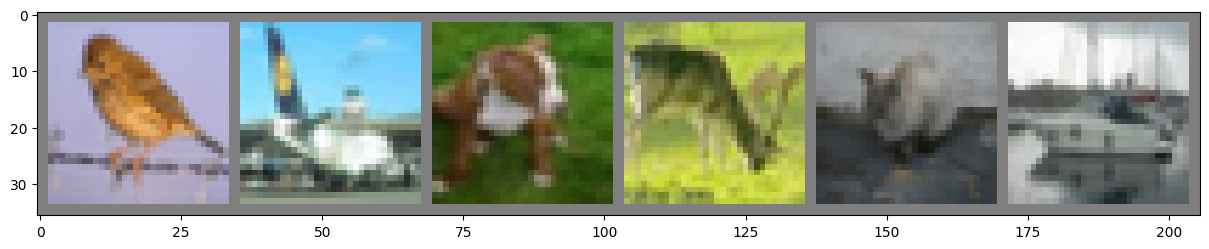

bird  plane dog   deer  cat   ship 


In [127]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


img_to_show = 6

def imshow(img, figsize=(15,15)):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:img_to_show]))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(img_to_show)))

## ResNet & ResNeXt block

In [128]:
class ResBlock(nn.Module):
    """
    resBlock_type: 'default', 'bottleneck', 'ResNeXt'
    """
    def __init__(
        self, 
        in_channels: int, 
        mid_channels: int, 
        out_channels: int, 
        resBlock_type: str = 'default',
        stride: int = 1, 
        padding: int = 1,
        kernel_size: int = 3, 
        activations: List[nn.Module] = [nn.ReLU()],
        cardinality: Optional[int] = 1,
        debug_mode: bool = False,
        # downsample: Optional[nn.Module] = None
    ):
        super(ResBlock, self).__init__()
        self.debug_mode = debug_mode
        self.activations = activations + activations[-1:]*(2 - len(activations))
        # self.activations += [nn.ReLU()]*(2 - len(activations))
        self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        self.cardinality = cardinality
        if (resBlock_type == 'default'):
                self.layers = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(out_channels),
                self.activations[0],
                nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels)
            )
            
        elif(resBlock_type == 'bottleneck'):
            self.layers = nn.Sequential(
                nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=1),
                nn.BatchNorm2d(mid_channels),
                self.activations[0],
                
                nn.Conv2d(mid_channels, mid_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(mid_channels),
                self.activations[1],
                
                nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=1),
                nn.BatchNorm2d(out_channels)
            )

        elif(resBlock_type == 'ResNeXt'):
            self.layers = nn.Sequential(
                nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=1),
                nn.BatchNorm2d(mid_channels),
                self.activations[0],
                nn.Conv2d(mid_channels, mid_channels, kernel_size=kernel_size, stride=stride, padding=1, groups=cardinality),
                nn.BatchNorm2d(mid_channels),
                self.activations[1],
                nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=1),
                nn.BatchNorm2d(out_channels)
            )
            
        else:
            raise Exception(f'Unknown block type: {resBlock_type}')
    
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self.shortcut = x
        x = self.layers(x)

        # if self.debug_mode:
        #     print(f'{x.shape = }')
        #     print(f'{self.shortcut.shape = }')
        #     print(f'{self.downsample = }')
        #     print(f'{(self.downsample(self.shortcut)).shape = }')
        
        x = self.activations[-1](x + self.downsample(self.shortcut)) # transform shortcut?
        return x 
        

In [129]:
print(ResBlock(2, 5, 3, stride=2, debug_mode=True)(torch.rand(1, 2, 32, 32)).shape)
print()
print(ResBlock(2, 5, 3, resBlock_type='bottleneck', stride=2, debug_mode=True)(torch.rand(1, 2, 32, 32)).shape)
print()
print(ResBlock(2, 5, 3, resBlock_type='ResNeXt', stride=2, debug_mode=True)(torch.rand(1, 2, 32, 32)).shape)
print()

torch.Size([1, 3, 16, 16])

torch.Size([1, 3, 16, 16])

torch.Size([1, 3, 16, 16])



## ResNet layer

In [130]:
# sequence of the blocks of the same type?
class ResLayer(nn.Module):
    def __init__(
        self,
        in_channels: int = 1,  
        mid_channels: Optional[int] = None,  
        out_channels: int = 1,
        block_type: str = 'default',
        num_blocks: int = 5,
        stride: int = 1,
        activations: List[nn.Module] = [nn.ReLU()],
        padding: int = 1,
        kernel_size: int = 3, 
        cardinality: int = 1,
    ):
        super(ResLayer, self).__init__()
        mid_channels = in_channels if (mid_channels is None) else mid_channels
            
        if num_blocks < 2:
            self.layer = nn.Sequential(ResBlock(in_channels, mid_channels, out_channels, 
                        block_type, stride, padding, kernel_size, activations, cardinality))
        else:
            self.layer = nn.Sequential(
                ResBlock(in_channels, mid_channels, mid_channels, 
                            block_type, stride, padding, kernel_size, activations, cardinality),
                *[ResBlock(in_channels, mid_channels, mid_channels, 
                    block_type, stride, padding, kernel_size, activations, cardinality) 
                    for _ in range(num_blocks - 2)],
                ResBlock(mid_channels, mid_channels, out_channels, 
                            block_type, stride, padding, kernel_size, activations, cardinality),
            )
        
    def forward(self, x):
        x = self.layer(x)
        return x

In [131]:
ResLayer(2, 4, 2)

ResLayer(
  (layer): Sequential(
    (0): ResBlock(
      (downsample): Conv2d(2, 4, kernel_size=(1, 1), stride=(1, 1))
      (layers): Sequential(
        (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResBlock(
      (downsample): Conv2d(2, 4, kernel_size=(1, 1), stride=(1, 1))
      (layers): Sequential(
        (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )

## ResNet

In [132]:
class ResNet(nn.Module):
    """
    architecture: Optional[int]: 18/32/50/101/152
    """
    def __init__(
        self,
        architecture: Optional[int] = None, 
        layer: Optional[List[int]] = None,
        block_types: Optional[List[str]] = ['default'],
        activations: List[nn.Module] = [nn.ReLU()],
        classes: int = 100,
        img_channels: int = 3, 
        img_height: int = 32, 
        img_width: int = 32,
    ):
        super(ResNet, self).__init__()
        if architecture is not None:
            self.channels = [64, 64, 128, 256, 512]
            if (architecture == 18):
                self.layers = [2, 2, 2, 2]
                self.blockType = ['default']*4
                
            elif (architecture == 50):
                self.layers = [3, 4, 6, 3]
                self.blockType = ['default']*4
                            
            elif (architecture == 101):
                self.layers = [3, 4, 23, 3]
                self.blockType = ['bottleneck']*4
                            
            elif (architecture == 152):
                self.layers = [3, 8, 36, 3]
                self.blockType = ['bottleneck']*4
                
            else:
                raise Exception(f'Unknown architecture: ResNet{architecture}. Only 18/32/50/101/152 available')
        
        else:
            self.layers = layer
            self.blockType = block_types + (['default']*(len(layer) - len(block_types)))
            self.channels = [64] + [2**(val + 6) for val in range(len(layer))]
        
        self.conv1 = nn.Conv2d(
            in_channels=img_channels, 
            out_channels=64, 
            kernel_size=7,
            stride=2,
            padding=3,
            )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.convX = nn.Sequential(
            *[ResLayer(
                    in_channels=self.channels[idx], 
                    out_channels=self.channels[idx+1],
                    block_type=self.blockType[idx],
                    num_blocks=layer,
                    activations=activations
                )
                for idx, layer in enumerate(self.layers)]
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.channels[-1], classes)
        
    def forward(self, x: torch.Tensor):
        x = self.conv1(x)  
        x = self.maxpool(x)
        x = self.convX(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x      
            
        
        

In [133]:
ResNet(18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (convX): Sequential(
    (0): ResLayer(
      (layer): Sequential(
        (0): ResBlock(
          (downsample): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (layers): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): ResBlock(
          (downsample): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (layers): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            

In [134]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split


In [135]:
# Transformations for the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load the CIFAR-10 training set
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create a subset of 1,000 images
train_indices, val_indices = train_test_split(list(range(len(train_dataset))), test_size=0.9, random_state=42)
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

# Create DataLoader for the subsets
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2)


Files already downloaded and verified


In [136]:
model = ResNet(architecture=18)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

print('Finished Training')


Epoch [1/3], Loss: 2.0615
Epoch [2/3], Loss: 1.8057
Epoch [3/3], Loss: 1.7335
Finished Training
